# Image Caption Generator with CNN & LSTM

You saw an image and your brain can easily tell what the image is about, but can a computer tell what the image is representing? Computer vision researchers worked on this a lot and they considered it impossible until now! With the advancement in Deep learning techniques, availability of huge datasets and computer power, we can build models that can generate captions for an image.

This is what we are going to implement in this Python based project where we will use deep learning techniques of Convolutional Neural Networks and a type of Recurrent Neural Network (LSTM) together.

## What is Image Caption Generator?

Image caption generator is a task that involves computer vision and natural language processing concepts to recognize the context of an image and describe them in a natural language like English.

### Image Caption Generator with CNN – About the Python based Project

The objective of our project is to learn the concepts of a CNN and LSTM model and build a working model of Image caption generator by implementing CNN with LSTM.

In this Python project, we will be implementing the caption generator using **CNN (Convolutional Neural Networks)*** and LSTM **(Long short term memory)**. The image features will be extracted from Xception which is a CNN model trained on the imagenet dataset and then we feed the features into the LSTM model which will be responsible for generating the image captions.

# The Dataset of Python based Project

For the image caption generator, we will be using the Flickr_8K dataset. There are also other big datasets like Flickr_30K and MSCOCO dataset but it can take weeks just to train the network so we will be using a small Flickr8k dataset. The advantage of a huge dataset is that we can build better models.

we get dataset from **Kaggle** you can download it from here also : <a href="https://www.kaggle.com/datasets/adityajn105/flickr8k">Kaggle-Flicker8k</a> (Size: 1GB).


#### Let's Begin to code.

# Import Modules

In [ ]:
import os   # handling the files
import pickle # storing numpy features
import numpy as np
from tqdm.notebook import tqdm # how much data is process till now

from tensorflow.keras.applications.vgg16 import VGG16 , preprocess_input # extract features from image data.
from tensorflow.keras.preprocessing.image import load_img , img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input , Dense , LSTM , Embedding , Dropout , add

**os** - used to handle files using system commands.

**pickle** - used to store numpy features extracted

**numpy** - used to perform a wide variety of mathematical operations on arrays

**tqdm** - progress bar decorator for iterators. Includes a default range iterator printing to stderr.

**VGG16, preprocess_input** - imported modules for feature extraction from the image data

**load_img, img_to_array** - used for loading the image and converting the image to a numpy array

**Tokenizer** - used for loading the text as convert them into a token

**pad_sequences** - used for equal distribution of words in sentences filling the remaining spaces with zeros

**plot_model** - used to visualize the architecture of the model through different images

#### Now we must set the directories to use the data

In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files

uploaded = files.upload()

# Make sure the uploaded file is named kaggle.json
# Move the file to the required directory
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


Saving kaggle.json to kaggle.json


In [ ]:
!kaggle datasets download -d adityajn105/flickr8k

 98% 1.01G/1.04G [00:08<00:00, 189MB/s]
100% 1.04G/1.04G [00:08<00:00, 131MB/s]


In [ ]:
!unzip flickr8k.zip -d flickr8k


Streaming output truncated to the last 5000 lines.
  inflating: flickr8k/Images/2844846111_8c1cbfc75d.jpg  
  inflating: flickr8k/Images/2844963839_ff09cdb81f.jpg  
  inflating: flickr8k/Images/2845246160_d0d1bbd6f0.jpg  
  inflating: flickr8k/Images/2845691057_d4ab89d889.jpg  
  inflating: flickr8k/Images/2845845721_d0bc113ff7.jpg  
  inflating: flickr8k/Images/2846037553_1a1de50709.jpg  
  inflating: flickr8k/Images/2846785268_904c5fcf9f.jpg  
  inflating: flickr8k/Images/2846843520_b0e6211478.jpg  
  inflating: flickr8k/Images/2847514745_9a35493023.jpg  
  inflating: flickr8k/Images/2847615962_c330bded6e.jpg  
  inflating: flickr8k/Images/2847859796_4d9cb0d31f.jpg  
  inflating: flickr8k/Images/2848266893_9693c66275.jpg  
  inflating: flickr8k/Images/2848571082_26454cb981.jpg  
  inflating: flickr8k/Images/2848895544_6d06210e9d.jpg  
  inflating: flickr8k/Images/2848977044_446a31d86e.jpg  
  inflating: flickr8k/Images/2849194983_2968c72832.jpg  
  inflating: flickr8k/Images/28507194

In [ ]:
BASE_DIR = '/content/flickr8k'
WORKING_DIR = '/content/sample_data'

# Extract Image Features

We have to load and restructure the model

VGG-16 is a convolutional neural network that is 16 layers deep. You can load a pretrained version of the network trained on more than a million images from the ImageNet database [1]. The pretrained network can classify images into 1000 object categories, such as keyboard, mouse, pencil, and many animals.

In [ ]:
# Load vgg16 Model
model = VGG16()

# restructure model
model = Model(inputs = model.inputs , outputs = model.layers[-2].output)

# Summerize
print(model.summary())

553467096/553467096 [==============================] - 3s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

+ Fully connected layer of the VGG16 model is not needed, just the previous layers to extract feature results.

+ By preference you may include more layers, but for quicker results avoid adding the unnecessary layers.

# extract the image features
Now we extract the image features and load the data for preprocess

In [ ]:
# import os
# from PIL import Image
# import matplotlib.pyplot as plt

# BASE_DIR = '/content/flickr8k'
# WORKING_DIR = '/content/sample_data'

# def generate_caption(image_name):
#     # Load the image
#     img_path = os.path.join(BASE_DIR, "Images", image_name)
#     image = Image.open(img_path)

#     # Assuming you have a mapping of image IDs to captions
#     image_id = image_name.split('.')[0]
#     captions = mapping.get(image_id, [])

#     print('---------------------Actual---------------------')
#     for caption in captions:
#         print(caption)

#     # Assuming you have a function to predict the caption for the image
#     y_pred = predict_caption(model, features[image_id], tokenizer, max_length)

#     print('--------------------Predicted--------------------')
#     print(y_pred)

#     plt.imshow(image)
#     plt.axis('off')
#     plt.show()

# # Example usage
# generate_caption("1001773457_577c3a7d70.jpg")


In [ ]:
# extract features from image
features = {}
directory = os.path.join(BASE_DIR, 'Images')

for img_name in tqdm(os.listdir(directory)):
    # load the image from file
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))
    # convert image pixels to numpy array
    image = img_to_array(image)
    # reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # preprocess image for vgg
    image = preprocess_input(image)
    # extract features
    feature = model.predict(image, verbose=0)
    # get image ID
    image_id = img_name.split('.')[0]
    # store feature
    features[image_id] = feature

  0%|          | 0/8091 [00:00<?, ?it/s]

Dictionary 'features' is created and will be loaded with the extracted features of image data

**load_img(img_path, target_size=(224, 224))** - custom dimension to resize the image when loaded to the array

**image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))** - reshaping the image data to preprocess in a RGB type image.

**model.predict(image, verbose=0)** - extraction of features from the image

**img_name.split('.')[0]** - split of the image name from the extension to load only the image name.

In [ ]:
# store features in pickle
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))

Extracted features are not stored in the disk, so re-extraction of features can extend running time

Dumps and store your dictionary in a pickle for reloading it to save time

In [ ]:
# load features from pickle
with open(os.path.join(WORKING_DIR, 'features.pkl'), 'rb') as f:
    features = pickle.load(f)

Load all your stored feature data to your project for quicker runtime

## Load the Captions Data

Let us store the captions data from the text file

In [ ]:
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

### Now we split and append the captions data with the image

In [ ]:
# create mapping of image to captions
mapping = {}
# process lines
for line in tqdm(captions_doc.split('\n')):
    # split the line by comma(,)
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

+ Dictionary 'mapping' is created with key as image_id and values as the corresponding caption text

+ Same image may have multiple captions, **if image_id not in mapping: mapping[image_id] = []** creates a list for appending captions to the corresponding image

#### Now let us see the no. of images loaded

In [ ]:
len(mapping)

8091

# Preprocess Text Data

In [ ]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars, etc.,
            caption = caption.replace('[^A-Za-z]', '')
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

Defined to clean and convert the text for quicker process and better results

Let us visualize the text **before** and **after** cleaning

In [ ]:
# before preprocess of text
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [ ]:
# preprocess the text
clean(mapping)

In [ ]:
# after preprocess of text
mapping['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

#### Next we will store the preprocessed captions into a list

In [ ]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [ ]:
len(all_captions)

40455

No. of unique captions stored

# 10 Captions
Let us see the first ten captions

In [ ]:
all_captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

# Processing of Text Data
Now we start processing the text data

In [ ]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [ ]:
vocab_size

8485

No. of unique words

In [ ]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

+ Finding the maximum length of the captions, used for reference for the padding sequence.

# Train Test Split

#### After preprocessing the data now we will train, test and split

In [ ]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

**Now we will define a batch and include the padding sequence**

In [ ]:
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq],num_classes=vocab_size)[0]
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

Padding sequence normalizes the size of all captions to the max size filling them with zeros for better results.

# Model Creation

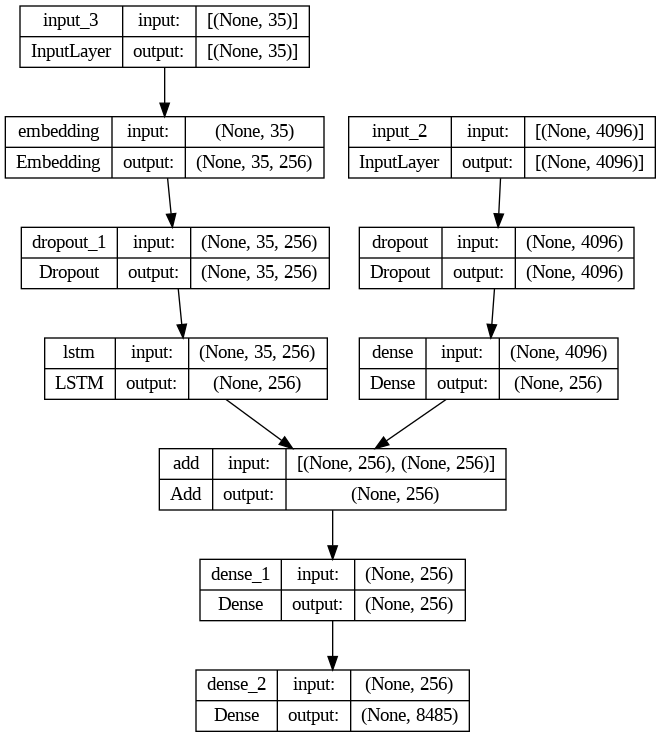

In [ ]:
# encoder model
# image feature layers
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
plot_model(model, show_shapes=True)

+ **shape=(4096,)** - output length of the features from the VGG model

+ **Dense** - single dimension linear layer array

+ **Dropout()** - used to add regularization to the data, avoiding over fitting & dropping out a fraction of the data from the layers

+ **model.compile()** - compilation of the model

+ **loss=’sparse_categorical_crossentropy’** - loss function for category outputs

+ **optimizer=’adam’** - automatically adjust the learning rate for the model over the no. of epochs

+ Model plot shows the concatenation of the inputs and outputs into a single layer

+ Feature extraction of image was already done using VGG, no CNN model was needed in this step.

# Train Model
Now let us train the model

In [ ]:
# train the model
epochs = 15
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

227/227 [==============================] - 60s 263ms/step - loss: 2.3508


+ **steps = len(train) // batch_size** - back propagation and fetch the next data

+ Loss decreases gradually over the iterations

+ Increase the no. of epochs for better results

+ Assign the no. of epochs and batch size accordingly for quicker results


### You can save the model in the working directory for reuse

In [ ]:
# save the model
model.save(WORKING_DIR+'/best_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Generate Captions for the Image

In [ ]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

+ Convert the predicted index from the model into a word

In [ ]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
    return in_text

+ Captiongenerator appending all the words for an image

+ The caption starts with 'startseq' and the model continues to predict the caption until the 'endseq' appeared

# Model Validation
Now we validate the data using BLEU Score

In [ ]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))


  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.518940
BLEU-2: 0.300868


+ BLEU Score is used to evaluate the predicted text against a reference text, in a list of tokens.

+ The reference text contains all the words appended from the captions data (actual_captions)

+ A BLEU Score more than **0.4 is considered a good result**, for a better score increase the no. of epochs accordingly.

## Visualize the Results

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    BASE_DIR = '/content/flickr8k'
    image_name = "1000268201_693b08cb0e.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

+ Image caption generator defined

+ First prints the actual captions of the image then prints a predicted caption of the image

---------------------Actual---------------------
startseq child in pink dress is climbing up set of stairs in an entry way endseq
startseq girl going into wooden building endseq
startseq little girl climbing into wooden playhouse endseq
startseq little girl climbing the stairs to her playhouse endseq
startseq little girl in pink dress going into wooden cabin endseq
--------------------Predicted--------------------
startseq woman in red shirt is standing on wooden bench endseq


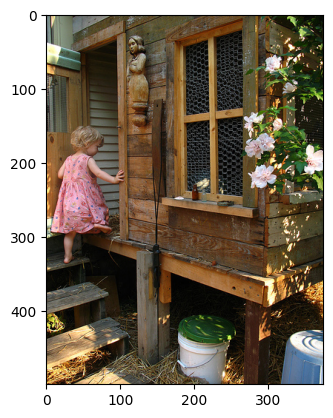

In [ ]:
generate_caption("1000268201_693b08cb0e.jpg")

---------------------Actual---------------------
startseq child in pink dress is climbing up set of stairs in an entry way endseq
startseq girl going into wooden building endseq
startseq little girl climbing into wooden playhouse endseq
startseq little girl climbing the stairs to her playhouse endseq
startseq little girl in pink dress going into wooden cabin endseq
--------------------Predicted--------------------
startseq woman in red shirt is standing on wooden bench endseq


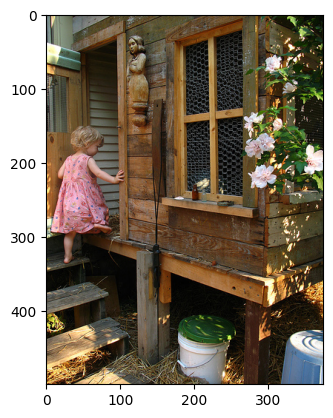

In [ ]:
generate_caption("1002674143_1b742ab4b8.jpg")

---------------------Actual---------------------
startseq child in pink dress is climbing up set of stairs in an entry way endseq
startseq girl going into wooden building endseq
startseq little girl climbing into wooden playhouse endseq
startseq little girl climbing the stairs to her playhouse endseq
startseq little girl in pink dress going into wooden cabin endseq
--------------------Predicted--------------------
startseq woman in red shirt is standing on wooden bench endseq


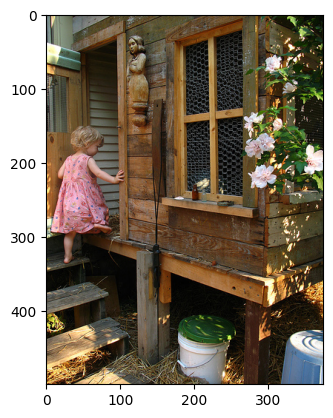

In [ ]:
generate_caption("101669240_b2d3e7f17b.jpg")

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    BASE_DIR = '/content/sample_data'
    image_name = "101669240_b2d3e7f17b.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
startseq man in hat is displaying pictures next to skier in blue hat endseq
startseq man skis past another man displaying paintings in the snow endseq
startseq person wearing skis looking at framed pictures set up in the snow endseq
startseq skier looks at framed pictures in the snow next to trees endseq
startseq man on skis looking at artwork for sale in the snow endseq
--------------------Predicted--------------------
startseq two skiers are riding their sled in the snow endseq


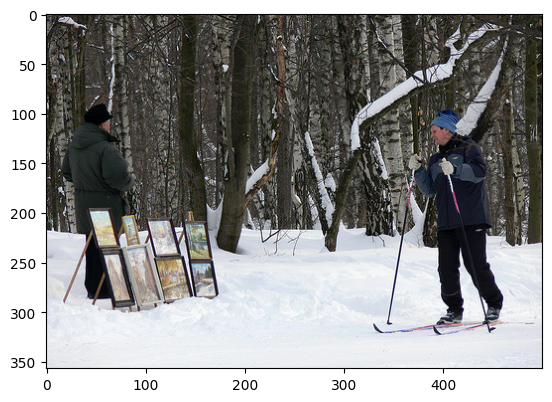

In [ ]:
generate_caption("101669240_b2d3e7f17b")

# Final Thoughts

+ Training the model by increasing the no. of epochs can give better and more accurate results.

+ Processing large amount of data can take a lot of time and system resource.

+ The no. of layers of the model can be increased if you want to process large dataset like flickr32k.



**In this project , we have built an Image Caption Generator exploring the Flickr Dataset as an advanced deep learning project using different models from image extraction and text based processing.**